In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from superfv import (
    OutputLoader,
    turbulent_power_specta,
)

In [2]:
base_path = "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/"

# Loop parameters
M_max_values = [1, 2.5, 5, 10, 25, 50]

seeds = range(1, 31)

common = dict(PAD={"rho": (0, None)}, SED=False)
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    lazy_primitives="full",
    MUSCL_limiter="PP2D",
    limiting_vars=("rho", "vx", "vy"),
    **common,
)

configs = {
    "p0": dict(p=0),
    "MUSCL-Hancock": dict(p=1, MUSCL=True, MUSCL_limiter="PP2D", **common),
    "ZS3": dict(p=3, GL=True, **apriori),
    "ZS7": dict(p=7, GL=True, **apriori),
    "ZS3t": dict(p=3, adaptive_dt=False, **apriori),
    "ZS7t": dict(p=7, adaptive_dt=False, **apriori),
    "MM3": dict(p=3, **aposteriori),
    "MM7": dict(p=7, **aposteriori),
    "MM3b": dict(p=3, blend=True, **aposteriori),
    "MM7b": dict(p=7, blend=True, **aposteriori),
    "MM3-2": dict(p=3, cascade="muscl1", max_MOOD_iters=2, **aposteriori),
    "MM7-2": dict(p=7, cascade="muscl1", max_MOOD_iters=2, **aposteriori),
    "MM3-3": dict(p=3, cascade="muscl1", max_MOOD_iters=3, **aposteriori),
    "MM7-3": dict(p=7, cascade="muscl1", max_MOOD_iters=3, **aposteriori),
}

# read simulation outputs
data = []
for (name, config), M_max in product(configs.items(), M_max_values):
    entry = dict(config=name, M_max=M_max, failed=0)
    for seed in seeds:
        sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"

        if not os.path.exists(sim_path):
            raise FileNotFoundError(sim_path)
        elif os.path.exists(sim_path + "error.txt"):
            entry["failed"] += 1
        elif os.path.exists(sim_path + "timings.txt"):
            continue
        else:
            raise FileNotFoundError("error.txt or timings.txt")
    data.append(entry)

df = pd.DataFrame(data)

In [3]:
df.pivot(index="M_max", columns="config", values="failed").loc[
    :,
    configs.keys(),
].sort_index(ascending=True)

config,p0,MUSCL-Hancock,ZS3,ZS7,ZS3t,ZS7t,MM3,MM7,MM3b,MM7b,MM3-2,MM7-2,MM3-3,MM7-3
M_max,,,,,,,,,,,,,,
1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2.5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5.0,0,0,0,0,29,30,7,2,0,0,0,0,0,0
10.0,0,0,0,0,30,30,27,26,2,3,0,0,0,0
25.0,0,0,0,0,30,30,30,30,17,24,1,0,0,0
50.0,0,0,0,0,30,30,30,30,22,25,0,0,0,0


Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/ZS3/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/ZS3t/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_10/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/ZS3/M_max_10/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_25/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/ZS3/M_max_25/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_50/seed_06"
Successful

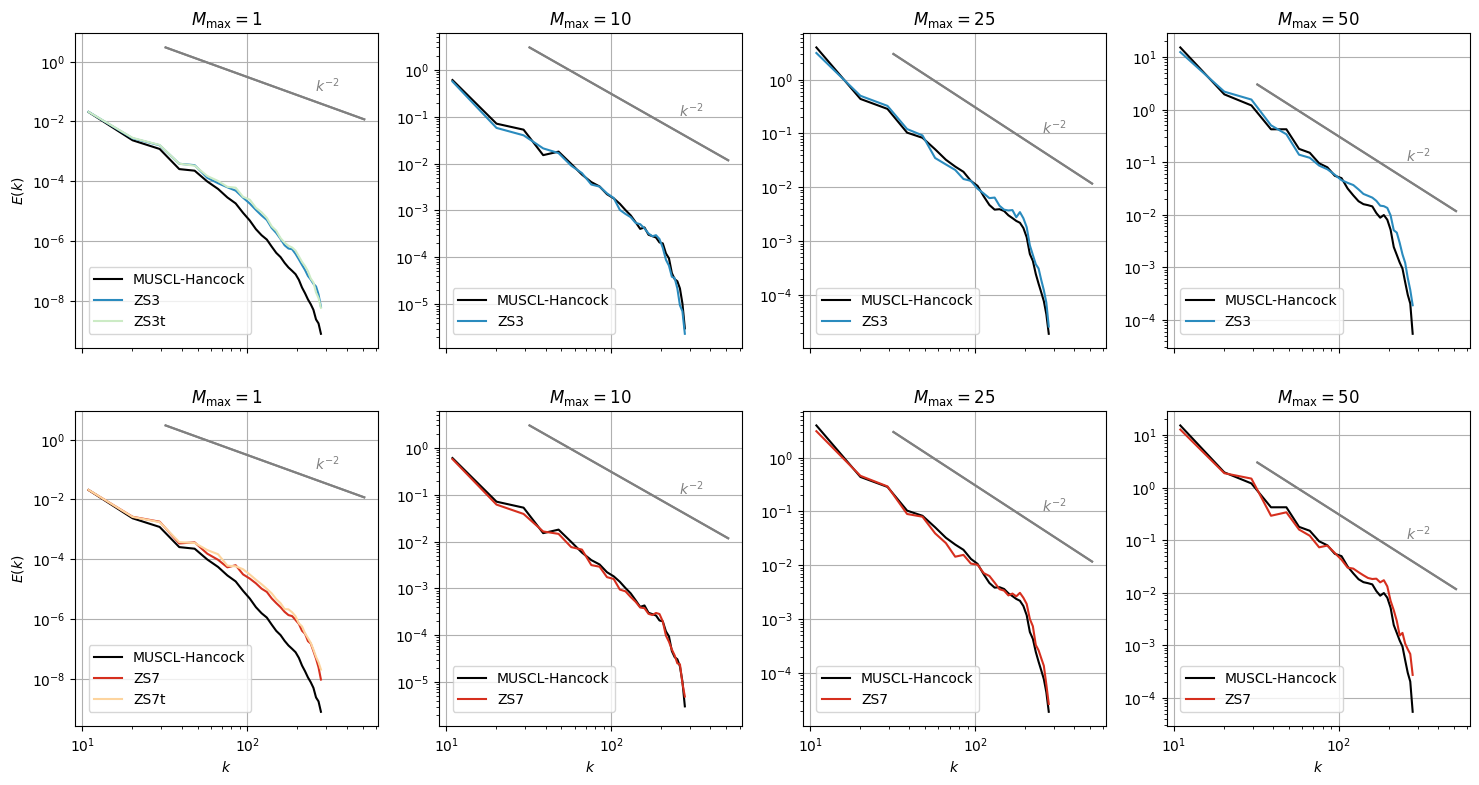

In [4]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey="col", figsize=(18, 9))

for i in range(2):
    for j in range(4):
        if i == 1:
            axs[1, j].set_xlabel(r"$k$")
        if j == 0:
            axs[i, 0].set_ylabel(r"$E(k)$")
        axs[i, j].set_xscale("log")
        axs[i, j].set_yscale("log")
        axs[i, j].grid()

M_max_values = [1, 10, 25, 50]
seed = 6
k = 3

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")

styles = {
    "MUSCL-Hancock": dict(color="k"),
    "ZS3": dict(color=cmap1(0.75)),
    "ZS7": dict(color=cmap2(0.75)),
    "ZS3t": dict(color=cmap1(0.25)),
    "ZS7t": dict(color=cmap2(0.25)),
}


def plot_power_law(ax, text=False):
    if text:
        ax.text(256, 0.1, r"$k^{-2}$", color="gray")
    ax.plot([32, 512], [3, 3 * (512 / 32) ** -2], color="gray")


for (i, j), M_max in zip([(0, 0), (0, 1), (0, 2), (0, 3)], M_max_values):
    for name in ["MUSCL-Hancock", "ZS3", "ZS3t"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            w = sim.snapshots[k]["w"]
            k_centers, E_k = turbulent_power_specta(
                np, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
            )

            axs[i, j].plot(
                k_centers,
                E_k,
                label=name,  # "-" if j > 0 else name,
                **styles[name],
            )
        except Exception:
            continue

    axs[i, j].legend(bbox_to_anchor=(0, 0), loc="lower left", borderaxespad=1)

    plot_power_law(axs[i, j])
    plot_power_law(axs[i, j], text=True)

    axs[i, j].set_title(rf"$M_\max={M_max}$")

for (i, j), M_max in zip([(1, 0), (1, 1), (1, 2), (1, 3)], M_max_values):
    for name in ["MUSCL-Hancock", "ZS7", "ZS7t"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            w = sim.snapshots[k]["w"]
            k_centers, E_k = turbulent_power_specta(
                np, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
            )
            axs[i, j].plot(
                k_centers,
                E_k,
                label=name,  # "-" if j > 0 else name,
                **styles[name],
            )
        except Exception:
            continue

    axs[i, j].legend(bbox_to_anchor=(0, 0), loc="lower left", borderaxespad=1)

    plot_power_law(axs[i, j])
    plot_power_law(axs[i, j], text=True)

    axs[i, j].set_title(rf"$M_\max={M_max}$")

In [5]:
fig.savefig("spectra-a-priori.png", dpi=100)

Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-3/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-2/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3b/M_max_1/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MUSCL-Hancock/M_max_10/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-3/M_max_10/seed_06"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/MM3-2/M_max_10/seed_06"
Successfully read simula

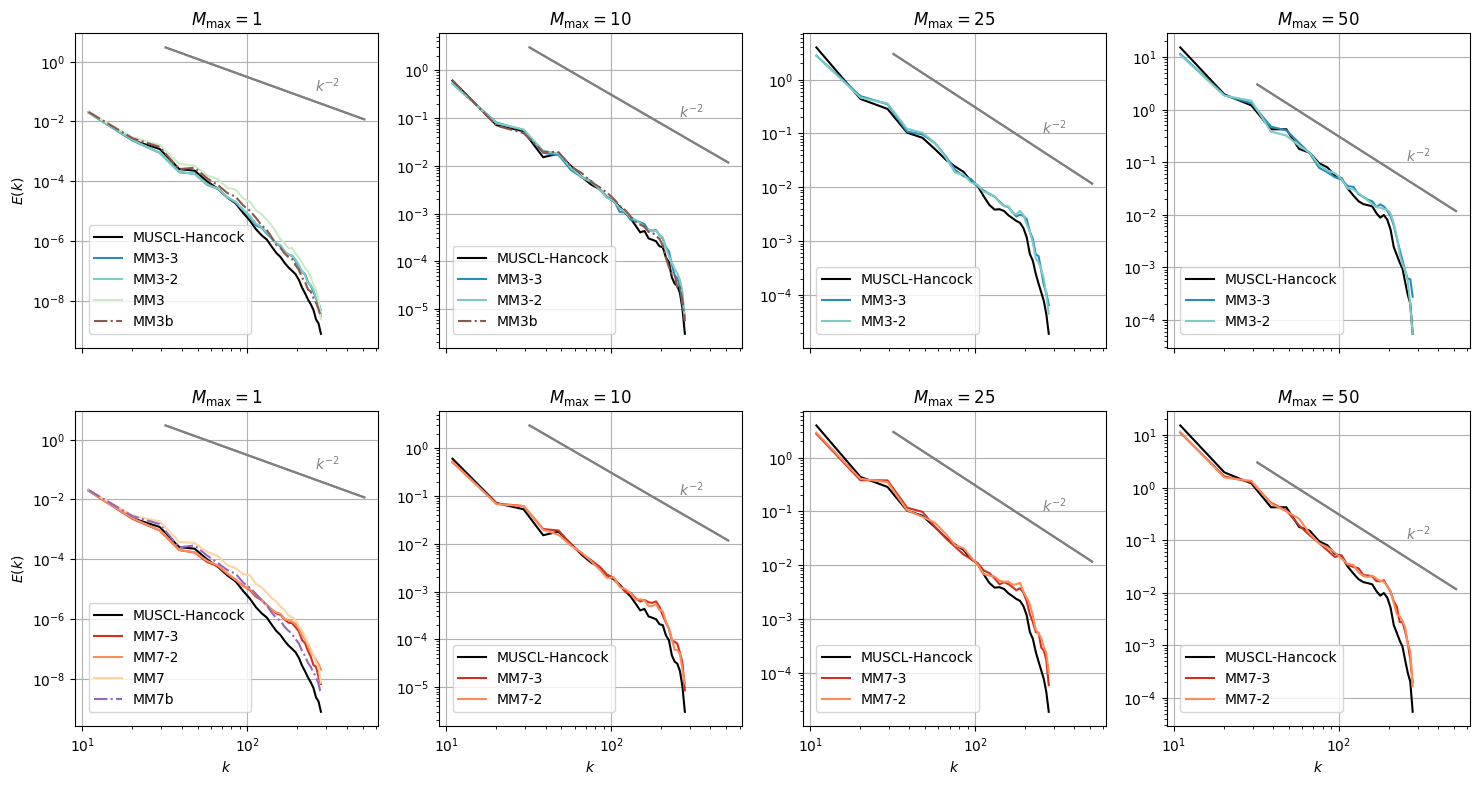

In [6]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey="col", figsize=(18, 9))

for i in range(2):
    for j in range(4):
        if i == 1:
            axs[1, j].set_xlabel(r"$k$")
        if j == 0:
            axs[i, 0].set_ylabel(r"$E(k)$")
        axs[i, j].set_xscale("log")
        axs[i, j].set_yscale("log")
        axs[i, j].grid()

M_max_values = [1, 10, 25, 50]
seed = 6
k = 3

cmap1 = plt.get_cmap("GnBu")
cmap2 = plt.get_cmap("OrRd")

styles = {
    "MUSCL-Hancock": dict(color="k"),
    "MM3": dict(color=cmap1(0.25)),
    "MM7": dict(color=cmap2(0.25)),
    "MM3-2": dict(color=cmap1(0.5)),
    "MM7-2": dict(color=cmap2(0.5)),
    "MM3-3": dict(color=cmap1(0.75)),
    "MM7-3": dict(color=cmap2(0.75)),
    "MM3b": dict(color="tab:brown", linestyle="-."),
    "MM7b": dict(color="tab:purple", linestyle="-."),
}


def plot_power_law(ax, text=False):
    if text:
        ax.text(256, 0.1, r"$k^{-2}$", color="gray")
    ax.plot([32, 512], [3, 3 * (512 / 32) ** -2], color="gray")


for (i, j), M_max in zip([(0, 0), (0, 1), (0, 2), (0, 3)], M_max_values):
    for name in ["MUSCL-Hancock", "MM3-3", "MM3-2", "MM3", "MM3b"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            w = sim.snapshots[k]["w"]
            k_centers, E_k = turbulent_power_specta(
                np, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
            )

            axs[i, j].plot(
                k_centers,
                E_k,
                label=name,  # "-" if j > 0 else name,
                **styles[name],
            )
        except Exception:
            continue

    axs[i, j].legend(bbox_to_anchor=(0, 0), loc="lower left", borderaxespad=1)

    plot_power_law(axs[i, j])
    plot_power_law(axs[i, j], text=True)

    axs[i, j].set_title(rf"$M_\max={M_max}$")

for (i, j), M_max in zip([(1, 0), (1, 1), (1, 2), (1, 3)], M_max_values):
    for name in ["MUSCL-Hancock", "MM7-3", "MM7-2", "MM7", "MM7b"]:
        try:
            sim_path = f"{base_path}{name}/M_max_{M_max}/seed_{seed:02d}/"
            sim = OutputLoader(sim_path)

            w = sim.snapshots[k]["w"]
            k_centers, E_k = turbulent_power_specta(
                np, sim.variable_index_map, w, sim.mesh, nbins=30, binmode="linear"
            )
            axs[i, j].plot(
                k_centers,
                E_k,
                label=name,  # "-" if j > 0 else name,
                **styles[name],
            )
        except Exception:
            continue

    axs[i, j].legend(bbox_to_anchor=(0, 0), loc="lower left", borderaxespad=1)

    plot_power_law(axs[i, j])
    plot_power_law(axs[i, j], text=True)

    axs[i, j].set_title(rf"$M_\max={M_max}$")

In [7]:
fig.savefig("spectra-a-posteriori.png", dpi=100)